# Lecture 4: Image Captioning with Visual Attention
## CSC5991 — Introduction to LLMs: "Attention Is All You Need"
### Slides 1–8 Companion Notebook

**Student Notes by:** Anik Tahabilder | **Email:** tahabilderanik@gmail.com

---

**What this notebook covers:**

| Section | Topic | Slides |
|---------|-------|--------|
| Part A | Recap — Attention Mechanisms | 2-5 |
| Part B | Image Captioning Task & Architecture | 6-8 |
| Part C | Hands-On — Building a Simplified Image Captioning Pipeline | — |
| Part D | Visualizing Attention on Real Images | — |
| Part E | Summary & Real-World Analogies | — |

> **Pre-requisites assumed:** Basic Python. That is it — every machine-learning
> concept is explained from scratch.

---
# Part 0 — Environment Setup

Before we write any machine-learning code we need to import a few libraries.
Do not worry if you have never seen these before; we will explain each one as
we use it.

| Library | What it does (plain English) |
|---------|-----------------------------|
| `torch` | The main deep-learning library (PyTorch). Think of it as a very powerful calculator that can also learn from data. |
| `torchvision` | A companion to PyTorch that ships with pre-trained image models and handy image utilities. |
| `matplotlib` | A plotting library — we use it to display images and graphs. |
| `numpy` | A library for fast number-crunching on arrays (tables of numbers). |
| `PIL` (Pillow) | A library for opening, resizing, and manipulating image files. |

In [1]:
# ============================================================
# 0.  Imports
# ============================================================
import torch                       # Core deep-learning library
import torch.nn as nn              # Neural-network building blocks
import torch.nn.functional as F    # Handy functions (softmax, relu, …)
import torchvision.models as models  # Pre-trained image models
import torchvision.transforms as T   # Image pre-processing pipelines

import numpy as np                 # Numerical arrays
import matplotlib.pyplot as plt    # Plotting / visualization
import matplotlib.cm as cm         # Colour maps for attention overlays
from PIL import Image              # Opening image files
import math, os, urllib.request    # Standard-library helpers

# Nicer plots inside the notebook
plt.rcParams['figure.dpi'] = 100

print("All imports succeeded!")
print(f"PyTorch version : {torch.__version__}")
print(f"CUDA available  : {torch.cuda.is_available()}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device    : {device}")

All imports succeeded!
PyTorch version : 2.10.0+cu128
CUDA available  : True
Using device    : cuda


---
# Part A — Recap: Attention Mechanisms (Slides 2-5)

Before we dive into image captioning, let us make sure we have a solid
understanding of **attention** — the single most important idea in modern AI.

## A.1  Why do we need Attention? — The Seq2Seq Bottleneck

### What is Seq2Seq?

**Seq2Seq** (Sequence-to-Sequence) is a family of models that convert one
sequence into another.  Common examples:

| Input sequence | Output sequence | Task |
|----------------|-----------------|------|
| "How are you?" (English) | "Comment allez-vous?" (French) | Machine Translation |
| An image (sequence of pixels) | "A dog playing in the park" | Image Captioning |
| A long article | A short summary | Text Summarization |

A Seq2Seq model has two parts:

1. **Encoder** — reads the entire input and compresses it into a single
   fixed-size vector (called the **context vector**).
2. **Decoder** — takes that context vector and generates the output one
   token (word) at a time.

### The Bottleneck Problem

Imagine you need to summarize a 500-page book, but you are only allowed to
write your notes on a single sticky note.  No matter how small your
handwriting is, you will lose information.  That sticky note is the
**context vector**.

```
 Input tokens ──▶ [ Encoder ] ──▶  single context vector  ──▶ [ Decoder ] ──▶ Output tokens
                                        ↑
                                   BOTTLENECK!
                           All information squeezed here
```

For short sentences this works okay, but for long inputs the fixed-size
vector simply cannot hold everything.  Performance degrades badly.

### The Fix: Attention

Instead of forcing the encoder to compress *everything* into one vector,
**attention** lets the decoder look back at *all* encoder outputs at every
decoding step and decide which parts are most relevant right now.

```
 Input tokens ──▶ [ Encoder ] ──▶  ALL hidden states h₁, h₂, …, hₙ
                                           │
                      ┌────────────────────┘
                      ▼
               [ Attention mechanism ]
                      │
                      ▼
              weighted context vector  ──▶ [ Decoder ] ──▶ next word
```

> **Real-world analogy:** When you translate a long paragraph, you do not
> memorize the whole thing first.  You keep glancing back at different parts
> of the source text as you write each translated word.  That "glancing
> back" is attention.

## A.2  Four Flavours of Attention

### 1. Additive Attention (Bahdanau, 2014)

This was the **first** attention mechanism used in neural machine
translation.  It works like this:

Given:
- **Decoder hidden state** `sₜ` (what the decoder is thinking right now)
- **Encoder hidden state** `hᵢ` (what the encoder captured at position *i*)

The **alignment score** is:

$$e_{t,i} = v^T \tanh(W_1 \, s_t + W_2 \, h_i)$$

Where `W₁`, `W₂`, and `v` are **learnable** weight matrices/vectors —
the model figures out the best values during training.

*Plain English:* We concatenate the decoder state and each encoder state,
pass them through a small neural network (one hidden layer with `tanh`),
and get a single number — "how relevant is encoder position *i* for the
current decoding step *t*?"

### 2. Dot-Product (Multiplicative) Attention (Luong, 2015)

A simpler and faster alternative:

$$e_{t,i} = s_t^T \, h_i$$

Just the **dot product** (element-wise multiply, then sum) of the two
vectors.  If the vectors point in similar directions the score is high.

### 3. Scaled Dot-Product Attention (Vaswani, 2017 — "Attention Is All You Need")

Same as dot-product but divided by $\sqrt{d_k}$ (square root of the
vector dimension) to prevent the dot products from growing too large:

$$e_{t,i} = \frac{s_t^T \, h_i}{\sqrt{d_k}}$$

This is the attention used inside **Transformers**.

### 4. Self-Attention vs Cross-Attention

| Type | Query comes from | Keys/Values come from | Example |
|------|-------------------|-----------------------|---------|
| **Self-Attention** | The same sequence | The same sequence | A sentence attending to itself to capture word relationships |
| **Cross-Attention** | One sequence (decoder) | Another sequence (encoder) | Decoder attending to encoder outputs |

Self-attention lets a sentence "look at itself" — for example, in
*"The cat sat on the mat because **it** was tired"*, self-attention
helps the model figure out that **it** refers to **the cat**.

## A.3  Attention Step-by-Step (with Code)

Let us walk through the three core steps of attention with tiny toy
numbers so you can see exactly what happens.

**The three steps:**
1. Compute **alignment scores** (how relevant is each encoder state?)
2. Convert scores to **attention weights** (using softmax — they sum to 1)
3. Compute the **context vector** (weighted sum of encoder states)

In [2]:
# ============================================================
# A.3  Toy Attention — step by step
# ============================================================

# ----- Fake data (imagine an encoder that processed 4 input words) -----
# Each encoder hidden state is a vector of size 8.
# In real models these would be hundreds or thousands of dimensions.

torch.manual_seed(42)  # For reproducibility

seq_len = 4      # 4 encoder positions (4 input words)
hidden_dim = 8   # Each hidden state has 8 numbers

# Encoder hidden states: shape (4, 8)
encoder_states = torch.randn(seq_len, hidden_dim)

# Current decoder hidden state: shape (8,)
decoder_state = torch.randn(hidden_dim)

print("=" * 60)
print("ENCODER HIDDEN STATES (one row per input position)")
print("=" * 60)
for i, h in enumerate(encoder_states):
    print(f"  h[{i}] = {h.tolist()[:4]}...  (showing first 4 of {hidden_dim} values)")

print(f"\nDECODER STATE (what the decoder is 'thinking' right now)")
print(f"  s   = {decoder_state.tolist()[:4]}...  (showing first 4 of {hidden_dim} values)")

ENCODER HIDDEN STATES (one row per input position)
  h[0] = [1.9269152879714966, 1.4872840642929077, 0.9007171988487244, -2.1055209636688232]...  (showing first 4 of 8 values)
  h[1] = [-0.7521352767944336, 1.6487230062484741, -0.3924786448478699, -1.4036071300506592]...  (showing first 4 of 8 values)
  h[2] = [1.6423169374465942, -0.1595974713563919, -0.4973975419998169, 0.439589262008667]...  (showing first 4 of 8 values)
  h[3] = [1.27912437915802, 1.2964228391647339, 0.610466480255127, 1.334737777709961]...  (showing first 4 of 8 values)

DECODER STATE (what the decoder is 'thinking' right now)
  s   = [1.322135090827942, 0.8171897530555725, -0.765838623046875, -0.7506223320960999]...  (showing first 4 of 8 values)


In [3]:
# ============================================================
# STEP 1 — Alignment scores  (dot-product attention)
# ============================================================
# For each encoder position i, compute:   score_i = decoder_state · encoder_states[i]
# The dot product measures similarity: high value = very relevant.

alignment_scores = torch.matmul(encoder_states, decoder_state)  # shape: (4,)

print("STEP 1: Alignment Scores (raw dot products)")
print("-" * 45)
for i, score in enumerate(alignment_scores):
    bar = "█" * int(max(0, score.item()) * 5)  # simple bar chart
    print(f"  score[{i}] = {score.item():+.4f}  {bar}")

print(f"\nInterpretation: Higher score → that encoder position is MORE")
print(f"relevant to what the decoder needs right now.")

STEP 1: Alignment Scores (raw dot products)
---------------------------------------------
  score[0] = +3.4624  █████████████████
  score[1] = +1.1967  █████
  score[2] = +2.8801  ██████████████
  score[3] = +1.7626  ████████

Interpretation: Higher score → that encoder position is MORE
relevant to what the decoder needs right now.


In [4]:
# ============================================================
# STEP 2 — Attention weights  (softmax turns scores into probabilities)
# ============================================================
# Softmax formula:  weight_i = exp(score_i) / sum(exp(score_j) for all j)
# This guarantees all weights are between 0 and 1 and sum to exactly 1.

attention_weights = F.softmax(alignment_scores, dim=0)  # shape: (4,)

print("STEP 2: Attention Weights (after softmax)")
print("-" * 45)
for i, w in enumerate(attention_weights):
    bar = "█" * int(w.item() * 40)
    print(f"  weight[{i}] = {w.item():.4f}  {bar}")

print(f"\n  Sum of weights = {attention_weights.sum().item():.4f}  (always 1.0)")
print(f"\nInterpretation: The decoder will 'pay' {attention_weights.max().item()*100:.1f}% of")
print(f"its attention to position {attention_weights.argmax().item()}.")

STEP 2: Attention Weights (after softmax)
---------------------------------------------
  weight[0] = 0.5420  █████████████████████
  weight[1] = 0.0562  ██
  weight[2] = 0.3028  ████████████
  weight[3] = 0.0990  ███

  Sum of weights = 1.0000  (always 1.0)

Interpretation: The decoder will 'pay' 54.2% of
its attention to position 0.


In [5]:
# ============================================================
# STEP 3 — Context vector  (weighted sum of encoder states)
# ============================================================
# context = weight[0]*h[0] + weight[1]*h[1] + weight[2]*h[2] + weight[3]*h[3]
# This is one vector that summarises the RELEVANT parts of the input.

context_vector = torch.matmul(attention_weights, encoder_states)  # shape: (8,)

print("STEP 3: Context Vector (weighted combination of encoder states)")
print("-" * 60)
print(f"  context = {context_vector.tolist()[:4]}...  (first 4 of {hidden_dim} values)")
print()
print("How it was computed (showing first element only):")
total = 0.0
for i in range(seq_len):
    contrib = attention_weights[i].item() * encoder_states[i][0].item()
    total += contrib
    print(f"  {attention_weights[i].item():.4f} * h[{i}][0]({encoder_states[i][0].item():+.4f}) = {contrib:+.4f}")
print(f"  {'─'*40}")
print(f"  context[0] = {total:+.4f}  (matches {context_vector[0].item():+.4f})")

STEP 3: Context Vector (weighted combination of encoder states)
------------------------------------------------------------
  context = [1.6259496212005615, 0.9788545370101929, 0.3759624660015106, -0.9548197984695435]...  (first 4 of 8 values)

How it was computed (showing first element only):
  0.5420 * h[0][0](+1.9269) = +1.0444
  0.0562 * h[1][0](-0.7521) = -0.0423
  0.3028 * h[2][0](+1.6423) = +0.4972
  0.0990 * h[3][0](+1.2791) = +0.1267
  ────────────────────────────────────────
  context[0] = +1.6259  (matches +1.6259)


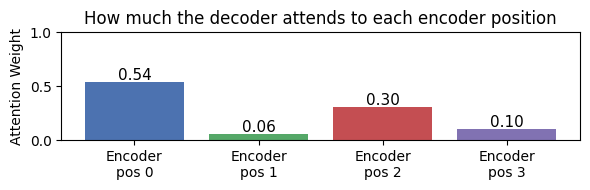

The tallest bar is where the decoder is 'looking' the hardest.


In [6]:
# ============================================================
# Visualize the attention weights
# ============================================================
fig, ax = plt.subplots(figsize=(6, 2))
ax.bar(range(seq_len), attention_weights.detach().numpy(), color=["#4C72B0","#55A868","#C44E52","#8172B2"])
ax.set_xticks(range(seq_len))
ax.set_xticklabels([f"Encoder\npos {i}" for i in range(seq_len)])
ax.set_ylabel("Attention Weight")
ax.set_title("How much the decoder attends to each encoder position")
ax.set_ylim(0, 1)
for i, w in enumerate(attention_weights):
    ax.text(i, w.item() + 0.02, f"{w.item():.2f}", ha="center", fontsize=11)
plt.tight_layout()
plt.show()
print("The tallest bar is where the decoder is 'looking' the hardest.")

## A.4  Additive (Bahdanau) Attention — Implementation

Let us now implement the Bahdanau attention as a proper PyTorch module.
This is important because it is the attention variant used in the
"Show, Attend and Tell" image captioning paper.

In [7]:
# ============================================================
# A.4  Bahdanau (Additive) Attention Module
# ============================================================

class BahdanauAttention(nn.Module):
    '''
    Additive attention (Bahdanau et al., 2014).

    Given:
        - encoder_out : all encoder hidden states   (batch, num_positions, encoder_dim)
        - decoder_h   : current decoder hidden state (batch, decoder_dim)
    Returns:
        - context     : weighted sum of encoder_out  (batch, encoder_dim)
        - weights     : attention weights             (batch, num_positions)
    '''
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        super().__init__()
        # W1 projects encoder states into attention space
        self.W1 = nn.Linear(encoder_dim, attention_dim)
        # W2 projects decoder state into the SAME attention space
        self.W2 = nn.Linear(decoder_dim, attention_dim)
        # v collapses the attention-space vector to a single score
        self.v  = nn.Linear(attention_dim, 1)

    def forward(self, encoder_out, decoder_h):
        # encoder_out shape: (batch, num_positions, encoder_dim)
        # decoder_h   shape: (batch, decoder_dim)

        # Project encoder states → (batch, num_positions, attention_dim)
        enc_proj = self.W1(encoder_out)

        # Project decoder state  → (batch, attention_dim)
        # We add a dimension so we can broadcast-add with enc_proj
        dec_proj = self.W2(decoder_h).unsqueeze(1)  # (batch, 1, attention_dim)

        # Combine and squash through tanh → (batch, num_positions, attention_dim)
        combined = torch.tanh(enc_proj + dec_proj)

        # Collapse to scores → (batch, num_positions, 1) → squeeze → (batch, num_positions)
        scores = self.v(combined).squeeze(2)

        # Softmax over positions → attention weights that sum to 1
        weights = F.softmax(scores, dim=1)  # (batch, num_positions)

        # Context = weighted sum of encoder outputs
        # weights: (batch, num_positions) → unsqueeze → (batch, 1, num_positions)
        # encoder_out: (batch, num_positions, encoder_dim)
        # bmm result:  (batch, 1, encoder_dim) → squeeze → (batch, encoder_dim)
        context = torch.bmm(weights.unsqueeze(1), encoder_out).squeeze(1)

        return context, weights

# Quick test
attn = BahdanauAttention(encoder_dim=8, decoder_dim=8, attention_dim=16)
test_enc = torch.randn(1, 4, 8)   # batch=1, 4 positions, dim=8
test_dec = torch.randn(1, 8)      # batch=1, dim=8
ctx, wts = attn(test_enc, test_dec)

print("Bahdanau Attention — quick test")
print(f"  Encoder output shape : {test_enc.shape}")
print(f"  Decoder state shape  : {test_dec.shape}")
print(f"  Context vector shape : {ctx.shape}")
print(f"  Attention weights    : {wts.detach().numpy().round(3)}")
print(f"  Weights sum          : {wts.sum().item():.4f}")
print("\nSuccess!  The attention module works correctly.")

Bahdanau Attention — quick test
  Encoder output shape : torch.Size([1, 4, 8])
  Decoder state shape  : torch.Size([1, 8])
  Context vector shape : torch.Size([1, 8])
  Attention weights    : [[0.186 0.199 0.354 0.26 ]]
  Weights sum          : 1.0000

Success!  The attention module works correctly.


---
# Part B — Image Captioning with Attention (Slides 6-8)

## B.1  What is Image Captioning?

**Image captioning** is the task of automatically generating a natural-language
description of an image.

```
  ┌───────────────┐
  │               │       "A brown dog is
  │   [photo of   │  ───▶  playing with a
  │    a dog]     │        frisbee in a park"
  │               │
  └───────────────┘
       INPUT                  OUTPUT
      (image)           (English sentence)
```

This is a **multimodal** task — it combines **vision** (understanding the
image) with **language** (producing a grammatical sentence).

### Why is it hard?

The model must:
1. **Recognise** objects (dog, frisbee, park)
2. **Understand** relationships (the dog is *playing with* the frisbee)
3. **Generate** fluent language (correct grammar, natural word order)

### The COCO Captions Dataset

The most famous benchmark is **MS-COCO (Common Objects in Context)**.
It contains:

| Statistic | Value |
|-----------|-------|
| Training images | ~83,000 |
| Validation images | ~41,000 |
| Captions per image | 5 (written by different humans) |
| Total captions | ~620,000 |

Each image has 5 different captions because different people describe
the same image differently.  For example, one image might have:

1. *"A group of people standing around a table with food."*
2. *"Several friends enjoying a meal together."*
3. *"People gathered for dinner at a restaurant."*
4. *"A dining scene with multiple plates of food."*
5. *"Friends sharing a meal at a large table."*

All five are valid — the model just needs to produce something
reasonable.

## B.2  Encoder-Decoder Architecture for Image Captioning

The architecture mirrors the Seq2Seq framework we saw in Part A, but
the **encoder** processes an image (not text) and the **decoder**
generates a caption word by word.

```
                        ENCODER                              DECODER
                   ┌──────────────┐                    ┌──────────────────┐
                   │              │   feature vectors   │                  │
   Image ────────▶ │  CNN         │ ─────────────────▶  │  RNN + Attention │ ──▶ "A dog playing …"
   (224×224)       │  (ResNet)    │   (7×7 = 49         │  (LSTM)          │
                   │              │    spatial regions)  │                  │
                   └──────────────┘                    └──────────────────┘
```

### The Encoder: A Pre-trained CNN

A **CNN** (Convolutional Neural Network) is a type of neural network that
is especially good at understanding images.  It works by sliding small
filters across the image, detecting patterns like edges, textures, and
eventually whole objects.

We do **not** train a CNN from scratch.  Instead, we use one that has
already been trained on **ImageNet** (a huge dataset of 1.2 million
images across 1,000 categories).  This pre-trained CNN has already
learned to "see".

Popular choices:

| Model | Year | Key Idea |
|-------|------|----------|
| **VGG** | 2014 | Very deep (16-19 layers) with small 3×3 filters |
| **ResNet** | 2015 | *Residual connections* — lets information skip layers, enabling 100+ layers |
| **ViT** | 2020 | Uses a *Transformer* (not a CNN!) to process image patches |

We will use **ResNet-101** in this notebook.

### What does the CNN produce?

Normally, a CNN ends with a **fully-connected layer** that outputs a
single vector (e.g., "85 percent chance this is a dog").  But for
captioning, we **remove** that final layer and instead take the output
of the **last convolutional layer**.

This gives us a **spatial feature map**: a grid of feature vectors, one
for each region of the image.

```
Original image (224 × 224 pixels)
        │
        ▼
CNN convolutional layers
        │
        ▼
Feature map:  7 × 7 grid  ×  2048 channels
        │
        ▼
Reshape to:  49 vectors, each of dimension 2048

Each of the 49 vectors describes one REGION of the image.
```

**Why a grid and not a single vector?**  Because attention needs
multiple positions to choose from!  Each of the 49 spatial positions
corresponds to a different part of the image.  The decoder can then
"look at" different regions when generating different words.

### The Decoder: An RNN (LSTM) with Attention

An **RNN** (Recurrent Neural Network) processes sequences one step at a
time, maintaining a "memory" (hidden state) that carries information
from previous steps.  An **LSTM** (Long Short-Term Memory) is a popular
variant that is better at remembering long-range dependencies.

At each time step, the decoder:
1. Uses **attention** to compute a context vector from the encoder features
2. Combines the context vector with the previous word's embedding
3. Feeds this into the LSTM
4. Predicts the next word

```
  Time step t:

  encoder features (49 × 2048)
         │
         ▼
  ┌─────────────────┐
  │   ATTENTION      │◀──── decoder hidden state hₜ₋₁
  │   mechanism      │
  └────────┬────────┘
           │ context vector cₜ
           ▼
  ┌─────────────────┐
  │   LSTM cell      │◀──── previous word embedding eₜ₋₁
  │                  │
  └────────┬────────┘
           │ new hidden state hₜ
           ▼
  ┌─────────────────┐
  │   Linear + Softmax │──▶ word probabilities
  └─────────────────┘
           │
           ▼
       predicted word wₜ
```

## B.3  Show and Tell vs. Show, Attend and Tell

These are two landmark papers in image captioning:

### Show and Tell (Vinyals et al., 2015)

- Uses a CNN encoder + LSTM decoder
- The CNN produces a **single** feature vector (from the final fully-connected layer)
- This vector is fed as the **initial hidden state** of the LSTM
- The LSTM then generates the caption — but it **never looks back** at the image
- This is the **bottleneck** approach

### Show, Attend and Tell (Xu et al., 2015)

- Also uses a CNN encoder + LSTM decoder
- But the CNN produces **spatial features** (a 7×7 grid = 49 vectors)
- At **every** decoding step, an **attention mechanism** lets the decoder
  focus on different image regions
- Much better captions, especially for complex scenes

| Feature | Show and Tell | Show, Attend and Tell |
|---------|---------------|----------------------|
| Encoder output | Single vector (4096-d) | Grid of vectors (49 × 2048) |
| Decoder input | Fixed initial state | Dynamic attention at every step |
| Can focus on regions? | No | Yes |
| Bottleneck problem? | Yes | No |
| Caption quality | Good for simple images | Better for complex scenes |
| Year | 2015 | 2015 |

### Hard Attention vs. Soft Attention

The "Show, Attend and Tell" paper introduces two variants:

| | Soft Attention | Hard Attention |
|---|---|---|
| **How it works** | Weighted average of ALL regions (like we coded above) | Picks ONE region at random (sampling) |
| **Differentiable?** | Yes — can train with standard backpropagation | No — needs reinforcement learning (REINFORCE) |
| **Deterministic?** | Yes — same input always gives same output | No — stochastic (random) |
| **Training** | Easier | Harder |
| **Used in practice?** | Almost always | Rarely |

> **Analogy:** Soft attention is like looking at a photo through a lens
> where different areas are more or less in focus (all visible, but some
> sharper).  Hard attention is like shining a narrow flashlight beam on
> one specific spot.

In this notebook, we implement **soft attention** (the standard choice).

---
# Part C — Building a Simplified Image Captioning Pipeline

We will now build every component of the encoder-decoder-attention
pipeline from scratch (in simplified form), using PyTorch.

## C.1  The CNN Encoder

We will:
1. Load a **pre-trained ResNet-101**
2. Remove its final classification layers
3. Keep only the convolutional backbone that produces spatial features

In [8]:
# ============================================================
# C.1  CNN Encoder — extract spatial features from an image
# ============================================================

class CNNEncoder(nn.Module):
    '''
    Uses a pre-trained ResNet-101 to extract spatial features from an image.

    Input:  image tensor of shape (batch, 3, 224, 224)
    Output: feature map of shape (batch, 49, 2048)
            — 49 spatial regions, each described by a 2048-dimensional vector

    Think of it as dividing the image into a 7×7 grid and describing
    each cell of that grid with 2048 numbers.
    '''
    def __init__(self, encoded_dim=2048):
        super().__init__()

        # Load a ResNet-101 that was pre-trained on ImageNet
        # (1.2 million images, 1000 categories — it already knows how to "see")
        resnet = models.resnet101(weights=models.ResNet101_Weights.DEFAULT)

        # We want the convolutional features, NOT the classification head.
        # ResNet architecture:
        #   conv1 → bn1 → relu → maxpool → layer1 → layer2 → layer3 → layer4 → avgpool → fc
        # We keep everything UP TO (and including) layer4.
        # layer4 output shape: (batch, 2048, 7, 7)

        modules = list(resnet.children())[:-2]   # Remove avgpool and fc
        self.backbone = nn.Sequential(*modules)

        # Freeze the CNN weights — we don't want to change them during our demo
        for param in self.backbone.parameters():
            param.requires_grad = False

        self.encoded_dim = encoded_dim

    def forward(self, images):
        '''
        images: (batch, 3, 224, 224)
        returns: (batch, 49, 2048) — 49 spatial feature vectors
        '''
        # Pass image through ResNet convolutional layers
        features = self.backbone(images)    # (batch, 2048, 7, 7)

        # Rearrange: (batch, 2048, 7, 7) → (batch, 2048, 49) → (batch, 49, 2048)
        batch_size = features.size(0)
        features = features.view(batch_size, self.encoded_dim, -1)  # (batch, 2048, 49)
        features = features.permute(0, 2, 1)                        # (batch, 49, 2048)

        return features

# Create the encoder
encoder = CNNEncoder().to(device)
encoder.eval()  # We only use it for inference (no training)

print("CNN Encoder created successfully!")
print(f"  Backbone: ResNet-101 (pre-trained on ImageNet)")
print(f"  Output  : (batch_size, 49 spatial positions, 2048 features)")
print(f"  Frozen  : Yes (we do not update CNN weights)")

CNN Encoder created successfully!
  Backbone: ResNet-101 (pre-trained on ImageNet)
  Output  : (batch_size, 49 spatial positions, 2048 features)
  Frozen  : Yes (we do not update CNN weights)


## C.2  Load a Demo Image

Let us load an image and extract its CNN features.  We will download
a sample image from the internet and preprocess it the way ResNet expects.

Could not download image (HTTP Error 403: Forbidden). Creating a synthetic image instead.
Created synthetic 224x224 image as fallback.


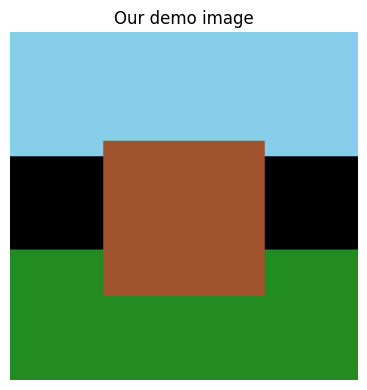

In [9]:
# ============================================================
# C.2  Download a sample image and preprocess it
# ============================================================

# Download a sample image (a dog on a beach)
image_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/YellowLabradorLooking_new.jpg/1200px-YellowLabradorLooking_new.jpg"
image_path = "/tmp/sample_dog.jpg"

try:
    if not os.path.exists(image_path):
        urllib.request.urlretrieve(image_url, image_path)
    raw_image = Image.open(image_path).convert("RGB")
    print(f"Image loaded: {raw_image.size[0]}×{raw_image.size[1]} pixels")
    image_loaded = True
except Exception as e:
    print(f"Could not download image ({e}). Creating a synthetic image instead.")
    # Create a synthetic colorful image as fallback
    np.random.seed(42)
    synthetic = np.zeros((224, 224, 3), dtype=np.uint8)
    # Blue sky on top
    synthetic[:80, :, :] = [135, 206, 235]
    # Green grass on bottom
    synthetic[140:, :, :] = [34, 139, 34]
    # Brown dog-like blob in center
    synthetic[70:170, 60:164, :] = [160, 82, 45]
    raw_image = Image.fromarray(synthetic)
    image_loaded = True
    print("Created synthetic 224x224 image as fallback.")

# Display the image
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.imshow(raw_image)
ax.set_title("Our demo image")
ax.axis("off")
plt.tight_layout()
plt.show()

In [10]:
# ============================================================
# C.2b  Preprocess the image for ResNet
# ============================================================

# ResNet expects:
#   1. Image resized to 256×256, then center-cropped to 224×224
#   2. Pixel values in [0, 1]
#   3. Normalised with ImageNet mean and std

preprocess = T.Compose([
    T.Resize(256),                           # Resize shortest side to 256
    T.CenterCrop(224),                       # Crop center 224×224
    T.ToTensor(),                            # Convert to tensor, scale to [0,1]
    T.Normalize(mean=[0.485, 0.456, 0.406], # Subtract ImageNet mean
                std=[0.229, 0.224, 0.225])   # Divide by ImageNet std
])

# Apply preprocessing
image_tensor = preprocess(raw_image).unsqueeze(0).to(device)  # Add batch dim → (1, 3, 224, 224)

print(f"Preprocessed image tensor shape: {image_tensor.shape}")
print(f"  Batch size : 1")
print(f"  Channels   : 3 (Red, Green, Blue)")
print(f"  Height     : 224 pixels")
print(f"  Width      : 224 pixels")
print(f"  Value range: [{image_tensor.min().item():.2f}, {image_tensor.max().item():.2f}]")

Preprocessed image tensor shape: torch.Size([1, 3, 224, 224])
  Batch size : 1
  Channels   : 3 (Red, Green, Blue)
  Height     : 224 pixels
  Width      : 224 pixels
  Value range: [-2.12, 2.29]


Extracted feature map shape: torch.Size([1, 49, 2048])
  Batch size       : 1
  Spatial positions: 49  (7×7 grid = 49 regions)
  Feature dimension: 2048

Each of the 49 vectors describes one region of the image.
The attention mechanism will learn which regions matter for each word.



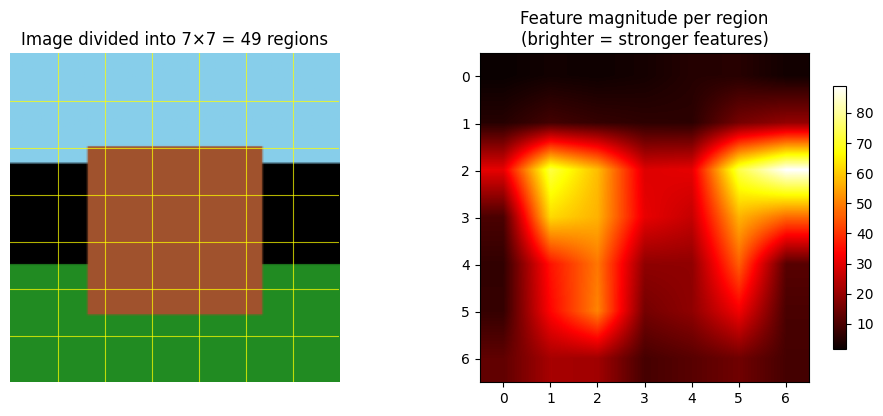

Left: The 7×7 grid shows how the CNN divides the image into regions.
Right: Some regions have stronger features (more 'interesting' content).


In [11]:
# ============================================================
# C.2c  Extract CNN features
# ============================================================

with torch.no_grad():  # No need to compute gradients — saves memory
    features = encoder(image_tensor)  # (1, 49, 2048)

print(f"Extracted feature map shape: {features.shape}")
print(f"  Batch size       : {features.shape[0]}")
print(f"  Spatial positions: {features.shape[1]}  (7×7 grid = 49 regions)")
print(f"  Feature dimension: {features.shape[2]}")
print()
print("Each of the 49 vectors describes one region of the image.")
print("The attention mechanism will learn which regions matter for each word.")
print()

# Show which part of the image each spatial position corresponds to
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Left: original image with grid overlay
ax = axes[0]
# We need to undo the normalization for display
inv_normalize = T.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
display_tensor = inv_normalize(image_tensor.squeeze(0).cpu())
display_img = display_tensor.permute(1, 2, 0).clamp(0, 1).numpy()
ax.imshow(display_img)
# Draw 7×7 grid
for i in range(1, 7):
    ax.axhline(y=i*32, color='yellow', linewidth=0.8, alpha=0.7)
    ax.axvline(x=i*32, color='yellow', linewidth=0.8, alpha=0.7)
ax.set_title("Image divided into 7×7 = 49 regions")
ax.axis("off")

# Right: heatmap of feature magnitudes
ax = axes[1]
# Compute the average magnitude of each spatial position's feature vector
feat_magnitudes = features[0].norm(dim=1).cpu().numpy()  # (49,)
feat_grid = feat_magnitudes.reshape(7, 7)
im = ax.imshow(feat_grid, cmap="hot", interpolation="bilinear")
ax.set_title("Feature magnitude per region\n(brighter = stronger features)")
ax.set_xticks(range(7))
ax.set_yticks(range(7))
plt.colorbar(im, ax=ax, shrink=0.8)

plt.tight_layout()
plt.show()
print("Left: The 7×7 grid shows how the CNN divides the image into regions.")
print("Right: Some regions have stronger features (more 'interesting' content).")

## C.3  The Attention Module

We already built a `BahdanauAttention` in Part A. Let us use it here as
the attention mechanism that sits between the encoder and decoder.

In [12]:
# ============================================================
# C.3  Attention Module for Image Captioning
# ============================================================
# We reuse our BahdanauAttention from Part A.
# Quick recap of what it does:
#
#   Input:
#     encoder_out : (batch, 49, encoder_dim)  — CNN spatial features
#     decoder_h   : (batch, decoder_dim)      — LSTM hidden state
#
#   Output:
#     context     : (batch, encoder_dim)      — weighted combination of features
#     weights     : (batch, 49)               — where the model is "looking"

# Already defined above — let's verify it works with our real features
test_decoder_h = torch.randn(1, 512).to(device)  # Typical LSTM hidden size

# We need to project the 2048-d features to a smaller dim for the demo
feature_projection = nn.Linear(2048, 512).to(device)
projected_features = feature_projection(features)  # (1, 49, 512)

attn_module = BahdanauAttention(
    encoder_dim=512,
    decoder_dim=512,
    attention_dim=256
).to(device)

with torch.no_grad():
    ctx, wts = attn_module(projected_features, test_decoder_h)

print("Attention module test with real CNN features:")
print(f"  Projected features shape : {projected_features.shape}")
print(f"  Decoder hidden state     : {test_decoder_h.shape}")
print(f"  Context vector shape     : {ctx.shape}")
print(f"  Attention weights shape  : {wts.shape}")
print(f"  Attention weights sum    : {wts.sum().item():.4f}")
print(f"  Top-3 attended positions : {wts[0].topk(3).indices.tolist()}")

Attention module test with real CNN features:
  Projected features shape : torch.Size([1, 49, 512])
  Decoder hidden state     : torch.Size([1, 512])
  Context vector shape     : torch.Size([1, 512])
  Attention weights shape  : torch.Size([1, 49])
  Attention weights sum    : 1.0000
  Top-3 attended positions : [24, 17, 31]


## C.4  The Decoder with Attention (LSTM)

Now we build the complete decoder that generates a caption one word at a
time.  At each step it:

1. Computes attention over the 49 image regions
2. Combines the attention context with the previous word's embedding
3. Passes everything through an LSTM cell
4. Predicts the next word

### Vocabulary

Real captioning models have vocabularies of ~10,000 words.  For our
simplified demo, we will use a tiny vocabulary to keep things clear.

In [13]:
# ============================================================
# C.4  Decoder with Attention
# ============================================================

class DecoderWithAttention(nn.Module):
    '''
    LSTM decoder with Bahdanau attention for image captioning.

    At each time step:
      1. Attention produces a context vector from encoder features
      2. Context + previous word embedding -> LSTM input
      3. LSTM produces new hidden state
      4. Linear layer predicts next word
    '''
    def __init__(self, vocab_size, embed_dim, encoder_dim, decoder_dim, attention_dim):
        super().__init__()

        self.vocab_size = vocab_size
        self.encoder_dim = encoder_dim
        self.decoder_dim = decoder_dim

        # Attention mechanism (Bahdanau)
        self.attention = BahdanauAttention(encoder_dim, decoder_dim, attention_dim)

        # Word embedding: converts word index → dense vector
        # e.g., word "dog" (index 5) → [0.12, -0.34, 0.56, ...]
        self.embedding = nn.Embedding(vocab_size, embed_dim)

        # LSTM cell: the heart of the decoder
        # Input = context vector (encoder_dim) + word embedding (embed_dim)
        self.lstm_cell = nn.LSTMCell(encoder_dim + embed_dim, decoder_dim)

        # Projects encoder features to match decoder dimension
        self.encoder_proj = nn.Linear(encoder_dim, encoder_dim)

        # Output layer: decoder hidden state → word probabilities
        self.fc = nn.Linear(decoder_dim, vocab_size)

        # Initialize hidden state from encoder features
        self.init_h = nn.Linear(encoder_dim, decoder_dim)
        self.init_c = nn.Linear(encoder_dim, decoder_dim)

    def init_hidden_state(self, encoder_out):
        '''
        Compute initial LSTM hidden state from the mean of encoder features.
        encoder_out: (batch, 49, encoder_dim)
        '''
        mean_features = encoder_out.mean(dim=1)          # (batch, encoder_dim)
        h0 = torch.tanh(self.init_h(mean_features))      # (batch, decoder_dim)
        c0 = torch.tanh(self.init_c(mean_features))      # (batch, decoder_dim)
        return h0, c0

    def forward_step(self, encoder_out, h, c, prev_word_idx):
        '''
        One decoding step.

        Args:
            encoder_out   : (batch, 49, encoder_dim) -- CNN features
            h, c          : LSTM hidden and cell states
            prev_word_idx : (batch,) -- index of previous word

        Returns:
            word_logits   : (batch, vocab_size) -- scores for each word
            h, c          : updated LSTM states
            attn_weights  : (batch, 49) -- attention weights for visualization
        '''
        # Step 1: Attention — where should we look in the image?
        context, attn_weights = self.attention(encoder_out, h)
        # context shape: (batch, encoder_dim)

        # Step 2: Embed the previous word
        word_embed = self.embedding(prev_word_idx)  # (batch, embed_dim)

        # Step 3: Concatenate context + word embedding → LSTM input
        lstm_input = torch.cat([context, word_embed], dim=1)
        # lstm_input shape: (batch, encoder_dim + embed_dim)

        # Step 4: LSTM step
        h, c = self.lstm_cell(lstm_input, (h, c))
        # h shape: (batch, decoder_dim)

        # Step 5: Predict next word
        word_logits = self.fc(h)  # (batch, vocab_size)

        return word_logits, h, c, attn_weights

# ------------------------------------------------------------------
# Create a tiny vocabulary for demonstration
# ------------------------------------------------------------------
# In a real system this would have ~10,000 words learned from the dataset.
vocab = [
    "<start>",   # 0  — beginning of caption
    "<end>",     # 1  — end of caption
    "<pad>",     # 2  — padding token
    "a",         # 3
    "the",       # 4
    "dog",       # 5
    "cat",       # 6
    "is",        # 7
    "on",        # 8
    "in",        # 9
    "sitting",   # 10
    "running",   # 11
    "grass",     # 12
    "beach",     # 13
    "park",      # 14
    "brown",     # 15
    "yellow",    # 16
    "with",      # 17
    "ball",      # 18
    "field",     # 19
    "looking",   # 20
    "at",        # 21
    "camera",    # 22
    "outside",   # 23
]

word2idx = {w: i for i, w in enumerate(vocab)}
idx2word = {i: w for i, w in enumerate(vocab)}
vocab_size = len(vocab)

print(f"Vocabulary size: {vocab_size} words")
print(f"Sample mappings:")
for w in ["<start>", "dog", "sitting", "grass", "<end>"]:
    print(f"  '{w}' → index {word2idx[w]}")

Vocabulary size: 24 words
Sample mappings:
  '<start>' → index 0
  'dog' → index 5
  'sitting' → index 10
  'grass' → index 12
  '<end>' → index 1


In [14]:
# ============================================================
# C.4b  Instantiate the Decoder
# ============================================================

# Hyperparameters (settings that control the model architecture)
ENCODER_DIM   = 2048   # Matches ResNet output
EMBED_DIM     = 128    # Word embedding size (small for demo)
DECODER_DIM   = 256    # LSTM hidden state size
ATTENTION_DIM = 128    # Internal attention dimension

decoder = DecoderWithAttention(
    vocab_size    = vocab_size,
    embed_dim     = EMBED_DIM,
    encoder_dim   = ENCODER_DIM,
    decoder_dim   = DECODER_DIM,
    attention_dim = ATTENTION_DIM,
).to(device)

print("Decoder created!")
print(f"  Vocabulary size  : {vocab_size}")
print(f"  Embedding dim    : {EMBED_DIM}")
print(f"  Encoder dim      : {ENCODER_DIM}")
print(f"  Decoder dim      : {DECODER_DIM}")
print(f"  Attention dim    : {ATTENTION_DIM}")

# Count parameters
total_params = sum(p.numel() for p in decoder.parameters())
print(f"  Total parameters : {total_params:,}")

Decoder created!
  Vocabulary size  : 24
  Embedding dim    : 128
  Encoder dim      : 2048
  Decoder dim      : 256
  Attention dim    : 128
  Total parameters : 8,042,393


## C.5  Generating a Caption Step-by-Step

Now let us watch the decoder generate a caption **one word at a time**.

Since our model is **untrained**, the generated words will be random —
that is expected!  The point is to see the *mechanism* in action:
how attention weights shift across image regions at each step.

> **Note:** In a real system, you would train this model on hundreds of
> thousands of image-caption pairs for many hours.  After training, the
> attention weights and word predictions would be meaningful.

In [15]:
# ============================================================
# C.5  Step-by-step caption generation (greedy decoding)
# ============================================================

# Use the features we extracted earlier: shape (1, 49, 2048)
encoder_features = features  # from our CNN encoder

# Initialize decoder hidden states from encoder features
h, c = decoder.init_hidden_state(encoder_features)

# Start with the <start> token
current_word = torch.tensor([word2idx["<start>"]]).to(device)

# Storage for the generated caption and attention weights
generated_words = ["<start>"]
all_attention_weights = []

max_caption_length = 10  # Stop after 10 words (safety limit)

print("=" * 70)
print("STEP-BY-STEP CAPTION GENERATION")
print("=" * 70)
print(f"{'Step':>4} | {'Prev Word':<12} | {'Predicted Word':<15} | {'Top-3 Attended Regions'}")
print("-" * 70)

decoder.eval()  # Set to evaluation mode (disables dropout etc.)

with torch.no_grad():  # No gradient computation needed
    for step in range(max_caption_length):
        # --- One decoder step ---
        word_logits, h, c, attn_weights = decoder.forward_step(
            encoder_features, h, c, current_word
        )

        # Save attention weights for visualization
        all_attention_weights.append(attn_weights[0].cpu().numpy())  # (49,)

        # Greedy decoding: pick the word with highest score
        predicted_idx = word_logits.argmax(dim=1).item()
        predicted_word = idx2word.get(predicted_idx, "<unk>")
        generated_words.append(predicted_word)

        # Report
        top3_regions = attn_weights[0].topk(3)
        top3_str = ", ".join([f"pos {idx}({val:.2f})" for val, idx in
                              zip(top3_regions.values.tolist(), top3_regions.indices.tolist())])
        print(f"{step+1:>4} | {generated_words[-2]:<12} | {predicted_word:<15} | {top3_str}")

        # Stop if <end> token is generated
        if predicted_word == "<end>":
            break

        # Feed the predicted word as input to the next step
        current_word = torch.tensor([predicted_idx]).to(device)

print("-" * 70)
caption = " ".join(generated_words[1:])  # Exclude <start>
print(f"\nGenerated caption: \"{caption}\"")
print(f"\n(The words are random because the model is UNTRAINED.)")
print(f"(After training on COCO, this would produce meaningful captions!)")

STEP-BY-STEP CAPTION GENERATION
Step | Prev Word    | Predicted Word  | Top-3 Attended Regions
----------------------------------------------------------------------


   1 | <start>      | beach           | pos 0(0.03), pos 6(0.02), pos 2(0.02)
   2 | beach        | cat             | pos 0(0.03), pos 6(0.02), pos 2(0.02)
   3 | cat          | cat             | pos 0(0.03), pos 6(0.02), pos 2(0.02)
   4 | cat          | cat             | pos 0(0.03), pos 6(0.02), pos 2(0.02)
   5 | cat          | cat             | pos 0(0.03), pos 6(0.02), pos 2(0.02)
   6 | cat          | cat             | pos 0(0.03), pos 6(0.02), pos 2(0.02)
   7 | cat          | cat             | pos 0(0.03), pos 6(0.02), pos 2(0.02)
   8 | cat          | cat             | pos 0(0.03), pos 6(0.02), pos 2(0.02)
   9 | cat          | cat             | pos 0(0.03), pos 6(0.02), pos 2(0.02)
  10 | cat          | cat             | pos 0(0.03), pos 6(0.02), pos 2(0.02)
----------------------------------------------------------------------

Generated caption: "beach cat cat cat cat cat cat cat cat cat"

(The words are random because the model is UNTRAINED.)
(After training on COCO, this

---
# Part D — Visualizing Attention on Real Images

This is the most exciting part!  We will overlay the attention weights
on the original image to see which regions the decoder "looked at"
when generating each word.

Even though the model is untrained (so the attention patterns are random),
the visualization technique is exactly what researchers use to understand
trained models.

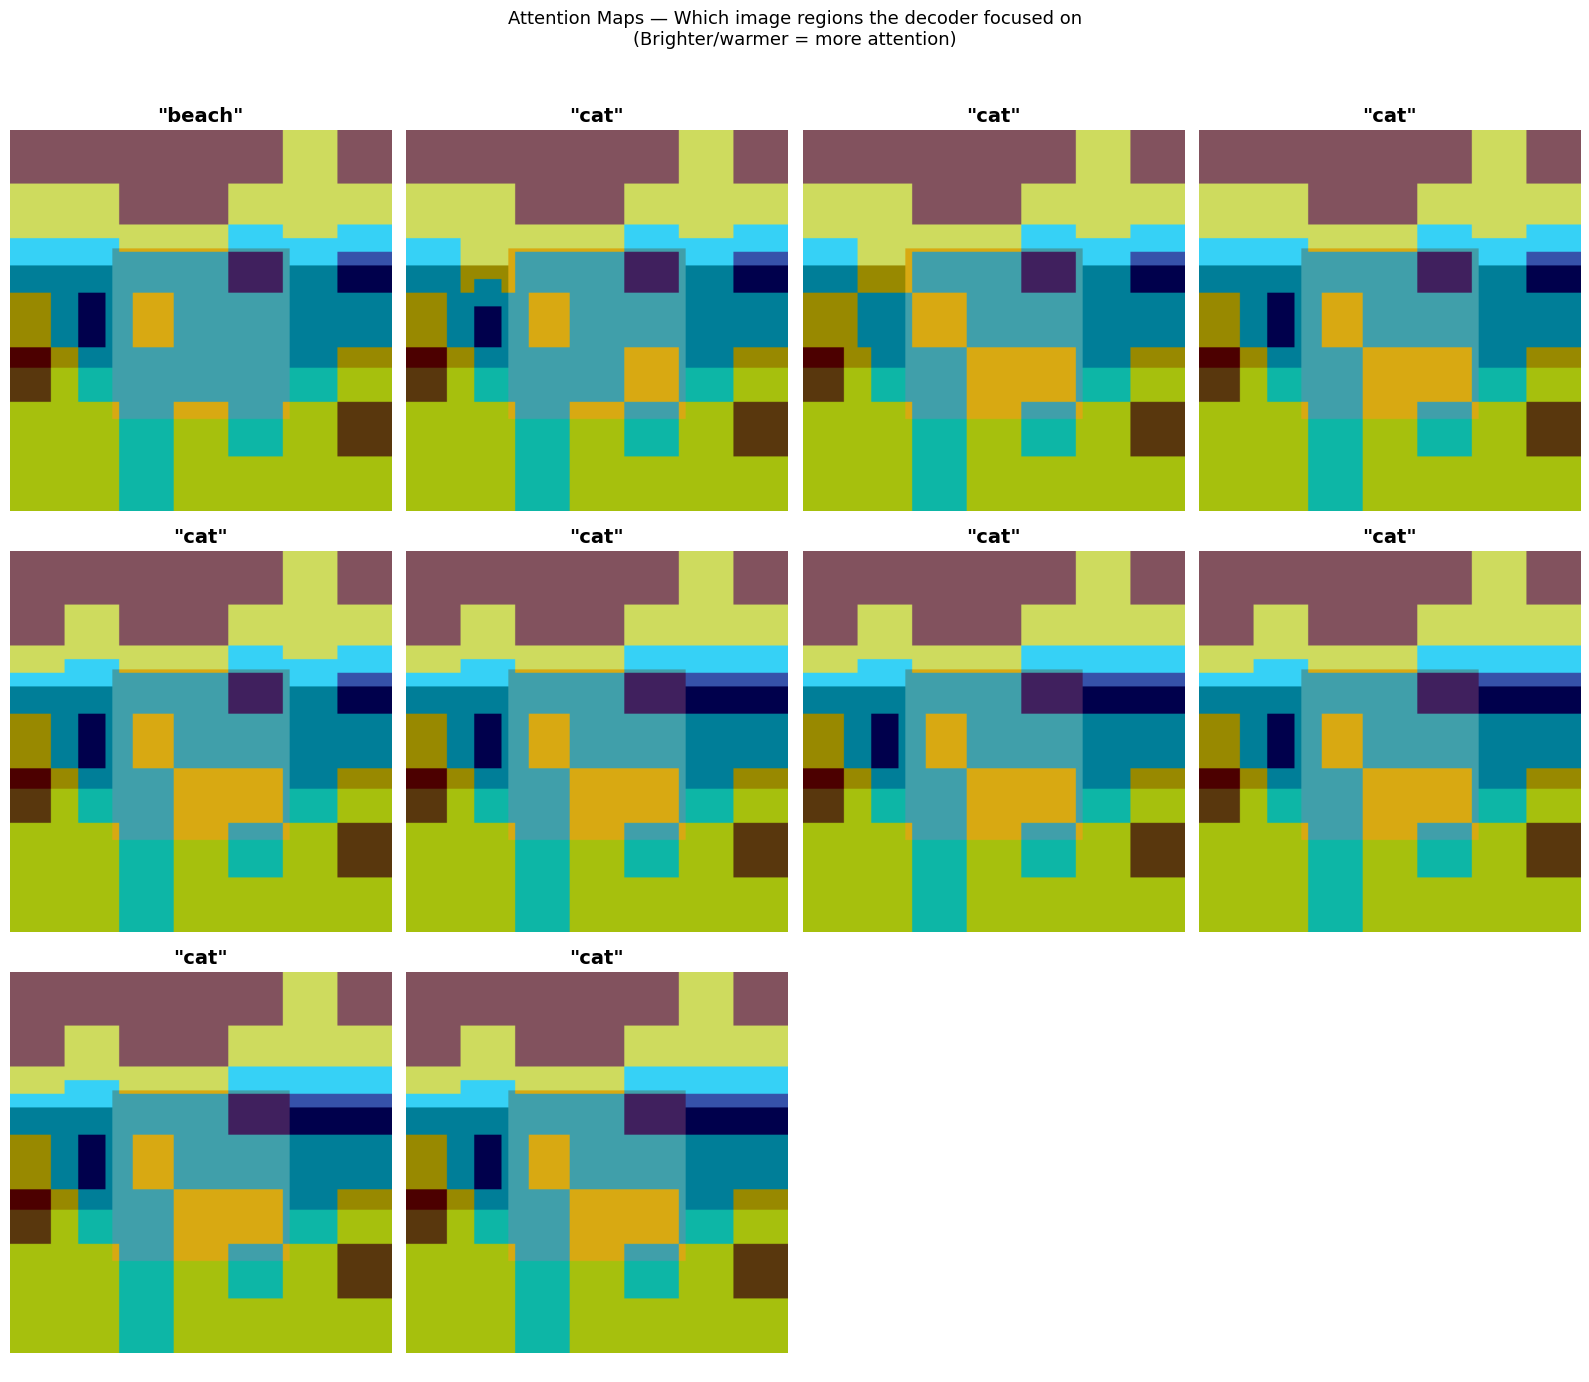

Each panel shows the attention map when the decoder predicted that word.
Warmer colours (red/yellow) = regions receiving MORE attention.
Cooler colours (blue)       = regions receiving LESS attention.

Since the model is UNTRAINED, the patterns are random.
After training on COCO, you would see meaningful patterns like:
  - "dog"  → attention on the dog region
  - "grass" → attention on the grass region
  - "sitting" → attention on the dog's posture


In [16]:
# ============================================================
# D.1  Visualize attention maps overlaid on the image
# ============================================================

def visualize_attention(image, words, attention_weights_list, smooth=True):
    '''
    Overlay attention weights on the image for each generated word.

    Args:
        image              : PIL Image (original)
        words              : list of generated words (excluding <start>)
        attention_weights_list : list of numpy arrays, each shape (49,)
        smooth             : if True, use bilinear interpolation for smoother maps
    '''
    num_words = min(len(words), len(attention_weights_list))
    if num_words == 0:
        print("No words to visualize.")
        return

    # Determine grid layout
    cols = min(4, num_words)
    rows = math.ceil(num_words / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4.5 * rows))
    if rows == 1 and cols == 1:
        axes = np.array([axes])
    axes = np.array(axes).flatten()

    # Resize image for display
    display_image = image.resize((224, 224))

    for idx in range(num_words):
        ax = axes[idx]

        # Show the original image
        ax.imshow(display_image)

        # Reshape attention weights from (49,) to (7, 7)
        attn_map = attention_weights_list[idx].reshape(7, 7)

        # Overlay the attention map with transparency
        if smooth:
            # Upscale to image size for smoother visualization
            attn_upscaled = np.array(Image.fromarray(
                (attn_map * 255).astype(np.uint8)
            ).resize((224, 224), Image.BILINEAR)) / 255.0
        else:
            attn_upscaled = np.kron(attn_map, np.ones((32, 32)))  # Blocky

        ax.imshow(attn_upscaled, alpha=0.6, cmap="jet")
        ax.set_title(f'"{words[idx]}"', fontsize=14, fontweight="bold")
        ax.axis("off")

    # Hide unused subplots
    for idx in range(num_words, len(axes)):
        axes[idx].axis("off")

    fig.suptitle("Attention Maps — Which image regions the decoder focused on\n"
                 "(Brighter/warmer = more attention)",
                 fontsize=13, y=1.02)
    plt.tight_layout()
    plt.show()

# Visualize
words_to_show = generated_words[1:]  # Skip <start>
visualize_attention(raw_image, words_to_show, all_attention_weights)

print("Each panel shows the attention map when the decoder predicted that word.")
print("Warmer colours (red/yellow) = regions receiving MORE attention.")
print("Cooler colours (blue)       = regions receiving LESS attention.")
print()
print("Since the model is UNTRAINED, the patterns are random.")
print("After training on COCO, you would see meaningful patterns like:")
print('  - "dog"  → attention on the dog region')
print('  - "grass" → attention on the grass region')
print('  - "sitting" → attention on the dog\'s posture')

## D.2  What Trained Attention Looks Like (Simulation)

Since training a full model takes hours on a GPU, let us **simulate**
what attention maps look like after proper training.  We will manually
craft attention weights that focus on sensible image regions to
demonstrate the concept.

Simulated 'trained' attention for: "a yellow dog looking at camera"
  'a         ' → peak attention at grid position (3, 3)
  'yellow    ' → peak attention at grid position (2, 3)
  'dog       ' → peak attention at grid position (2, 3)
  'looking   ' → peak attention at grid position (1, 3)
  'at        ' → peak attention at grid position (1, 4)
  'camera    ' → peak attention at grid position (1, 5)


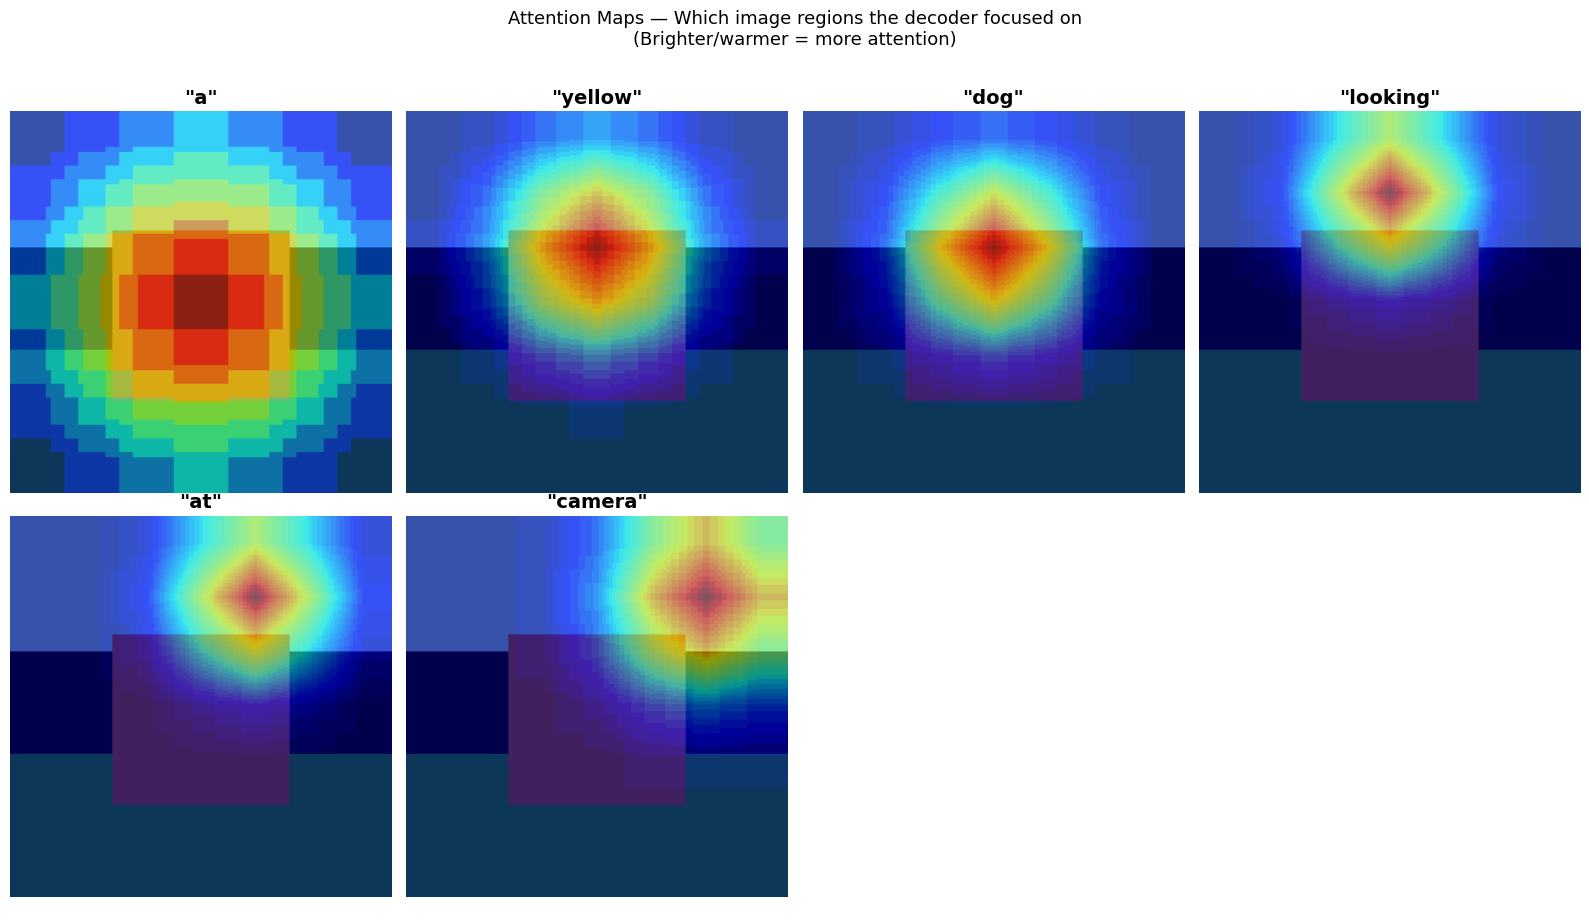


This is what a TRAINED model's attention looks like!
Key observations:
  - 'a' has diffuse attention (function word, no specific region)
  - 'dog' focuses on the central region where the dog is
  - 'looking' focuses on the face/eyes area
  - Different words attend to different image regions

This is the power of attention — it lets the model 'look at'
the right part of the image when generating each word.


In [17]:
# ============================================================
# D.2  Simulated "trained" attention visualization
# ============================================================
# We manually create attention maps that focus on specific image regions
# to show what a properly trained model would do.

def create_focused_attention(center_row, center_col, spread=1.0):
    '''
    Create a 7x7 attention map focused around (center_row, center_col).
    Uses a Gaussian-like distribution for smooth focus.
    '''
    attn = np.zeros((7, 7))
    for r in range(7):
        for c in range(7):
            dist = ((r - center_row)**2 + (c - center_col)**2)
            attn[r, c] = np.exp(-dist / (2 * spread))
    # Normalize to sum to 1
    attn = attn / attn.sum()
    return attn.flatten()  # (49,)

# Simulate a caption: "a yellow dog looking at camera"
# and create attention maps that focus on appropriate regions
simulated_words = ["a", "yellow", "dog", "looking", "at", "camera"]

simulated_attention = [
    create_focused_attention(3, 3, spread=5.0),    # "a" — broad, diffuse attention
    create_focused_attention(2, 3, spread=1.5),    # "yellow" — focus on dog's body colour
    create_focused_attention(2, 3, spread=1.2),    # "dog" — focus on the dog
    create_focused_attention(1, 3, spread=1.0),    # "looking" — focus on dog's face/eyes
    create_focused_attention(1, 4, spread=1.0),    # "at" — transition toward what it's looking at
    create_focused_attention(1, 5, spread=1.5),    # "camera" — focus on the direction of gaze
]

print("Simulated 'trained' attention for: \"a yellow dog looking at camera\"")
print("=" * 60)
for word, attn in zip(simulated_words, simulated_attention):
    attn_grid = attn.reshape(7, 7)
    peak_r, peak_c = np.unravel_index(attn_grid.argmax(), (7, 7))
    print(f"  '{word:10s}' → peak attention at grid position ({peak_r}, {peak_c})")

# Visualize
visualize_attention(raw_image, simulated_words, simulated_attention, smooth=True)

print("\nThis is what a TRAINED model's attention looks like!")
print("Key observations:")
print("  - 'a' has diffuse attention (function word, no specific region)")
print("  - 'dog' focuses on the central region where the dog is")
print("  - 'looking' focuses on the face/eyes area")
print("  - Different words attend to different image regions")
print("\nThis is the power of attention — it lets the model 'look at'")
print("the right part of the image when generating each word.")

## D.3  Show and Tell vs. Show, Attend and Tell — Visual Comparison

Let us visualize the key difference between the two approaches.

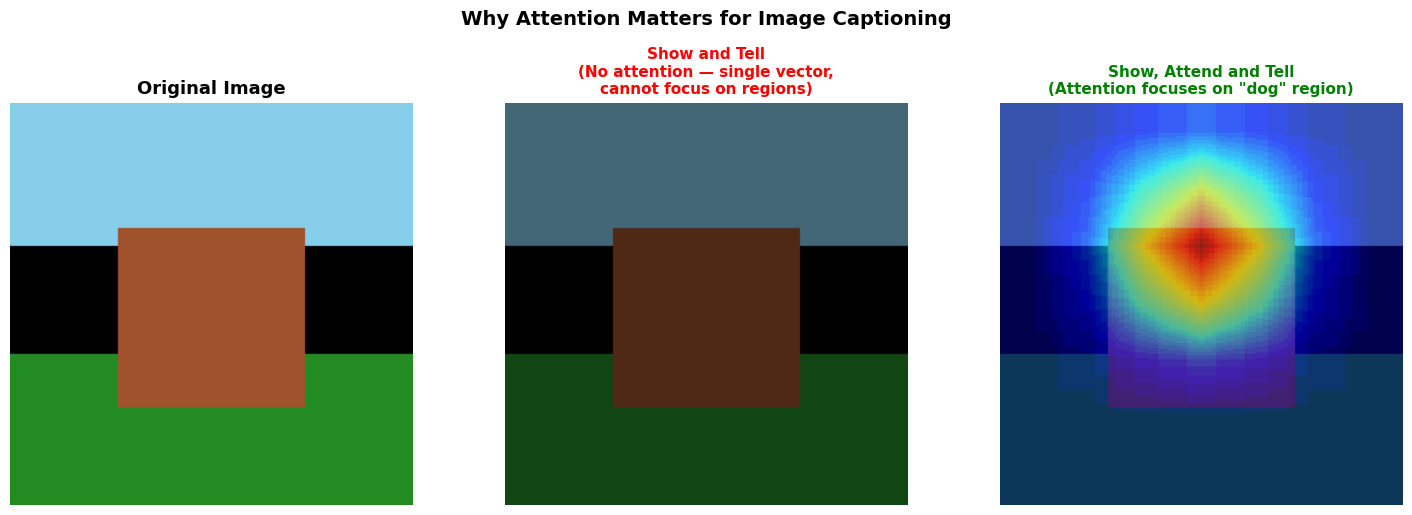

LEFT:   The original image.
MIDDLE: Without attention, the decoder gets a single vector summarizing
        the ENTIRE image — no ability to focus on specific regions.
RIGHT:  With attention, when generating the word 'dog', the decoder
        focuses specifically on the region containing the dog.


In [18]:
# ============================================================
# D.3  Visual comparison: with and without attention
# ============================================================

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# --- Panel 1: Original image ---
display_image = raw_image.resize((224, 224))
axes[0].imshow(display_image)
axes[0].set_title("Original Image", fontsize=13, fontweight="bold")
axes[0].axis("off")

# --- Panel 2: Show and Tell (no attention) ---
axes[1].imshow(display_image)
# Overlay a uniform grey — same weight everywhere (or rather, no spatial info at all)
uniform_overlay = np.ones((224, 224)) * 0.5
axes[1].imshow(uniform_overlay, alpha=0.5, cmap="gray")
axes[1].set_title("Show and Tell\n(No attention — single vector,\ncannot focus on regions)",
                  fontsize=11, fontweight="bold", color="red")
axes[1].axis("off")

# --- Panel 3: Show, Attend and Tell (with attention on "dog") ---
axes[2].imshow(display_image)
dog_attn = create_focused_attention(2, 3, spread=1.2).reshape(7, 7)
dog_attn_up = np.array(Image.fromarray(
    (dog_attn * 255).astype(np.uint8)).resize((224, 224), Image.BILINEAR)) / 255.0
axes[2].imshow(dog_attn_up, alpha=0.6, cmap="jet")
axes[2].set_title('Show, Attend and Tell\n(Attention focuses on "dog" region)',
                  fontsize=11, fontweight="bold", color="green")
axes[2].axis("off")

plt.suptitle("Why Attention Matters for Image Captioning", fontsize=14, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()

print("LEFT:   The original image.")
print("MIDDLE: Without attention, the decoder gets a single vector summarizing")
print("        the ENTIRE image — no ability to focus on specific regions.")
print("RIGHT:  With attention, when generating the word 'dog', the decoder")
print("        focuses specifically on the region containing the dog.")

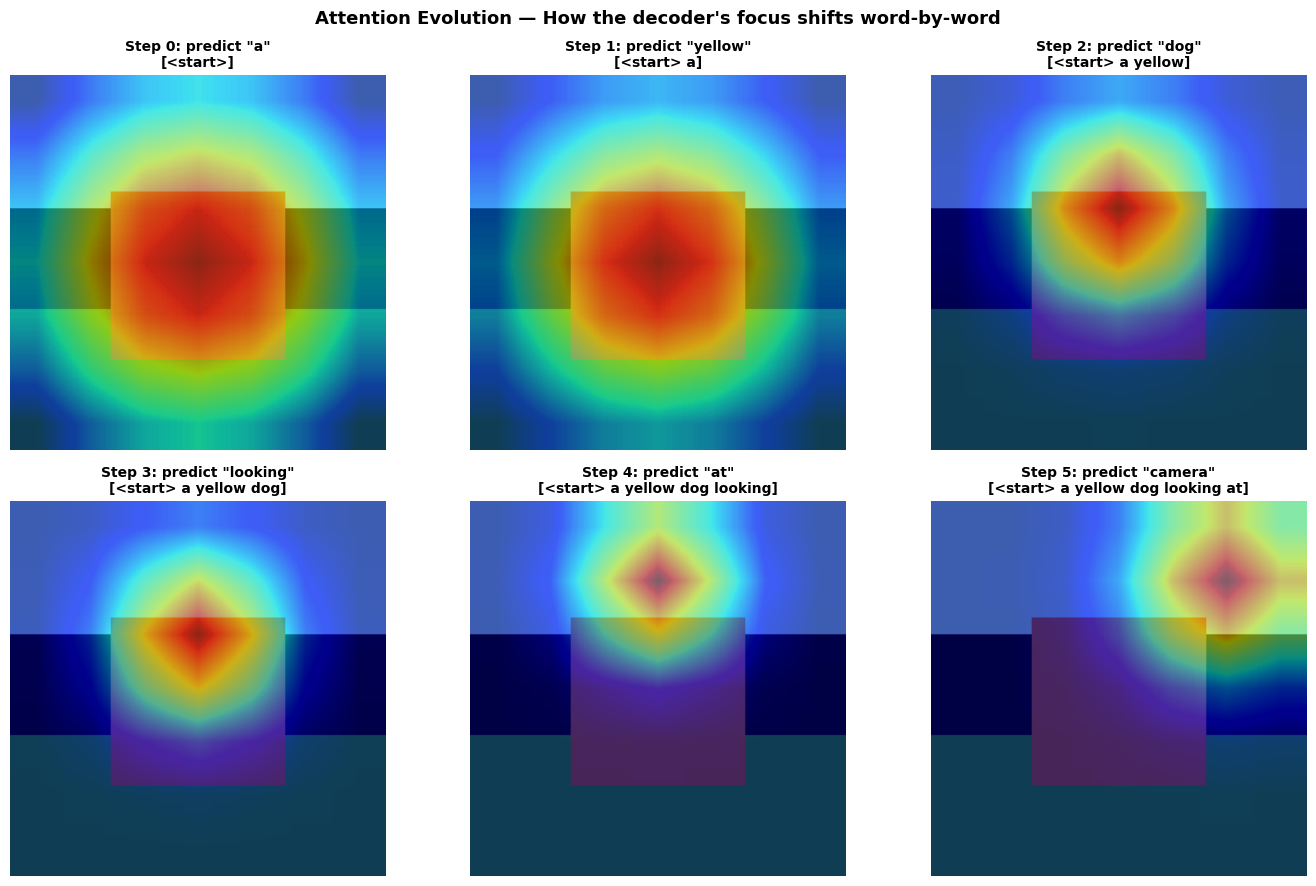

Notice how attention moves across the image as different words are generated:
  Step 0 (<start>): Broad overview — deciding what to describe
  Step 1 (a):       Still broad — 'a' is a function word
  Step 2 (yellow):  Focuses on the coloured body of the dog
  Step 3 (dog):     Focuses on the dog itself
  Step 4 (looking): Focuses on the face/head
  Step 5 (camera):  Shifts to the direction the dog is looking


In [19]:
# ============================================================
# D.4  How attention shifts over time during caption generation
# ============================================================

fig, axes = plt.subplots(2, 3, figsize=(14, 9))
axes = axes.flatten()

simulated_full = ["<start>", "a", "yellow", "dog", "looking", "at", "camera"]
simulated_attn_full = [
    create_focused_attention(3, 3, spread=8.0),    # <start> — very diffuse
    create_focused_attention(3, 3, spread=5.0),    # "a"
    create_focused_attention(2, 3, spread=1.5),    # "yellow"
    create_focused_attention(2, 3, spread=1.2),    # "dog"
    create_focused_attention(1, 3, spread=1.0),    # "looking"
    create_focused_attention(1, 5, spread=1.5),    # "camera"
]

display_image = raw_image.resize((224, 224))

for idx in range(6):
    ax = axes[idx]
    ax.imshow(display_image)
    attn_map = simulated_attn_full[idx].reshape(7, 7)
    attn_up = np.array(Image.fromarray(
        (attn_map / attn_map.max() * 255).astype(np.uint8)
    ).resize((224, 224), Image.BILINEAR)) / 255.0
    ax.imshow(attn_up, alpha=0.55, cmap="jet")

    generated_so_far = " ".join(simulated_full[:idx+1])
    next_word = simulated_full[idx+1] if idx+1 < len(simulated_full) else "<end>"
    ax.set_title(f'Step {idx}: predict "{next_word}"\n[{generated_so_far}]',
                 fontsize=10, fontweight="bold")
    ax.axis("off")

plt.suptitle("Attention Evolution — How the decoder's focus shifts word-by-word",
             fontsize=13, fontweight="bold")
plt.tight_layout()
plt.show()

print("Notice how attention moves across the image as different words are generated:")
print("  Step 0 (<start>): Broad overview — deciding what to describe")
print("  Step 1 (a):       Still broad — 'a' is a function word")
print("  Step 2 (yellow):  Focuses on the coloured body of the dog")
print("  Step 3 (dog):     Focuses on the dog itself")
print("  Step 4 (looking): Focuses on the face/head")
print("  Step 5 (camera):  Shifts to the direction the dog is looking")

---
# Part E — Putting It All Together

## E.1  Complete Architecture Diagram

Here is the full pipeline we have built, with every component labelled:

```
┌────────────────────────────────────────────────────────────────────────┐
│                    IMAGE CAPTIONING PIPELINE                          │
│                                                                       │
│  ┌─────────────┐                                                      │
│  │             │   Pre-trained                                        │
│  │   IMAGE     │   ResNet-101        ┌──────────────────────────┐     │
│  │  (224×224)  │──────────────────▶  │  SPATIAL FEATURES        │     │
│  │             │   (frozen CNN)      │  49 positions × 2048 dim │     │
│  └─────────────┘                     └───────────┬──────────────┘     │
│                                                  │                    │
│                                     ┌────────────┘                    │
│                                     │                                 │
│  ┌──────────────────────────────────┼────────────────────────────┐    │
│  │  DECODER (repeats for each word) │                            │    │
│  │                                  ▼                            │    │
│  │  ┌───────────────────────────────────────┐                    │    │
│  │  │ BAHDANAU ATTENTION                    │                    │    │
│  │  │                                       │                    │    │
│  │  │  encoder_features (49 × 2048)         │                    │    │
│  │  │         +                             │                    │    │
│  │  │  decoder_hidden_state (256)           │                    │    │
│  │  │         ↓                             │                    │    │
│  │  │  alignment scores → softmax           │                    │    │
│  │  │         ↓                             │                    │    │
│  │  │  attention_weights (49)               │  ← visualized!    │    │
│  │  │         ↓                             │                    │    │
│  │  │  context_vector (2048)                │                    │    │
│  │  └─────────────────┬─────────────────────┘                    │    │
│  │                    │                                          │    │
│  │                    ▼                                          │    │
│  │  ┌─────────────────────────────────┐                          │    │
│  │  │ CONCATENATE                      │                          │    │
│  │  │  context (2048) + embed (128)    │ ← previous word         │    │
│  │  └────────────────┬────────────────┘                          │    │
│  │                   │                                           │    │
│  │                   ▼                                           │    │
│  │  ┌─────────────────────────────────┐                          │    │
│  │  │ LSTM CELL                        │                          │    │
│  │  │  Input:  2048 + 128 = 2176       │                          │    │
│  │  │  Hidden: 256                     │                          │    │
│  │  └────────────────┬────────────────┘                          │    │
│  │                   │                                           │    │
│  │                   ▼                                           │    │
│  │  ┌─────────────────────────────────┐                          │    │
│  │  │ LINEAR (256 → vocab_size)        │                          │    │
│  │  │     + SOFTMAX                    │                          │    │
│  │  └────────────────┬────────────────┘                          │    │
│  │                   │                                           │    │
│  │                   ▼                                           │    │
│  │              PREDICTED WORD                                   │    │
│  │           (fed back as input)                                 │    │
│  └───────────────────────────────────────────────────────────────┘    │
│                                                                       │
│  Repeat until <end> token or max length reached                       │
└────────────────────────────────────────────────────────────────────────┘
```

## E.2  Summary Table — Everything We Covered

| Concept | What it is | Why it matters |
|---------|-----------|----------------|
| **Seq2Seq** | Encoder→Decoder architecture | Foundation for many generation tasks |
| **Bottleneck** | Compressing all input info into one vector | Limits performance on long/complex inputs |
| **Attention** | Dynamic weighted lookup over encoder states | Solves the bottleneck — decoder can look anywhere |
| **Additive Attention** | score = v·tanh(W₁s + W₂h) | First attention (Bahdanau 2014); used in image captioning |
| **Dot-Product Attention** | score = s·h | Simpler, faster; used in Transformers |
| **Self-Attention** | Sequence attends to itself | Captures internal relationships |
| **Cross-Attention** | One sequence attends to another | Decoder attends to encoder |
| **CNN Encoder** | Pre-trained CNN extracts spatial features | Provides rich visual representations |
| **Spatial Features** | 7×7 grid of 2048-d vectors | Gives attention 49 regions to choose from |
| **LSTM Decoder** | Generates words one at a time | Produces grammatical sentences |
| **Show and Tell** | CNN → single vector → LSTM | Simple but suffers from bottleneck |
| **Show, Attend and Tell** | CNN → spatial features → Attention + LSTM | Better captions via dynamic focus |
| **Soft Attention** | Weighted average of all regions | Differentiable, easy to train |
| **Hard Attention** | Sample one region | Needs reinforcement learning |

## E.3  Real-World Analogies

Understanding deep-learning concepts is much easier with everyday analogies.

### Analogy 1: The Tour Guide

Imagine you are a **tour guide** describing a painting to a blind person.

- **Without attention (Show and Tell):** You study the entire painting
  for 30 seconds, then turn away and describe it purely from memory.
  You might forget details — especially in a complex scene.

- **With attention (Show, Attend and Tell):** You keep the painting in
  front of you.  When you describe the *dog*, you look at the dog.
  When you describe the *grass*, you look at the grass.  You can
  always glance at the relevant part of the painting.

### Analogy 2: Reading a Textbook

- **Seq2Seq bottleneck:** Reading an entire chapter, closing the book,
  then trying to answer questions from memory.

- **Attention:** Keeping the book open and flipping to the relevant
  page/paragraph for each question.

### Analogy 3: Ordering at a Restaurant

- **Self-attention:** Before ordering, you look at what everyone else
  at *your* table ordered, so your choice is informed by context.

- **Cross-attention:** You look at what people at *another* table
  ordered (maybe they got something that looks good).

### Analogy 4: Soft vs. Hard Attention

- **Soft attention:** Looking at a group photo where some faces are in
  focus and others are slightly blurry — you see *all* of them, but
  some are clearer.

- **Hard attention:** Using a magnifying glass that can only show one
  face at a time — you see that one perfectly but miss the rest.

## E.4  Self-Test Questions

Test your understanding with these questions:

1. **Why can't a standard Seq2Seq model handle long inputs well?**
   <details><summary>Answer</summary>
   Because all information is compressed into a single fixed-size context vector (the bottleneck). For long inputs, important details get lost.
   </details>

2. **What are the three steps of the attention mechanism?**
   <details><summary>Answer</summary>
   (1) Compute alignment scores between decoder state and each encoder state. (2) Apply softmax to get attention weights (summing to 1). (3) Compute context vector as weighted sum of encoder states.
   </details>

3. **What is the difference between additive and dot-product attention?**
   <details><summary>Answer</summary>
   Additive: score = v·tanh(W₁s + W₂h) — uses a small neural network. Dot-product: score = s·h — just a dot product. Dot-product is simpler and faster.
   </details>

4. **Why do we use spatial features (7x7 grid) instead of a single vector from the CNN?**
   <details><summary>Answer</summary>
   Spatial features give the attention mechanism 49 different regions to choose from. A single vector would force all spatial information to be compressed, losing the ability to focus on specific image regions.
   </details>

5. **What is the key advantage of "Show, Attend and Tell" over "Show and Tell"?**
   <details><summary>Answer</summary>
   Show, Attend and Tell uses attention to dynamically focus on different image regions for each word, avoiding the bottleneck of compressing the entire image into a single vector. This produces better captions, especially for complex scenes.
   </details>

6. **Why is soft attention preferred over hard attention in practice?**
   <details><summary>Answer</summary>
   Soft attention is differentiable (you can compute gradients through it), so it can be trained with standard backpropagation. Hard attention requires reinforcement learning (REINFORCE algorithm), which is harder to train and less stable.
   </details>

## E.5  Key Takeaways

1. **Attention solves the bottleneck problem** by letting the decoder
   access all encoder states, not just a compressed summary.

2. **Image captioning** is a classic encoder-decoder task: CNN encoder
   extracts visual features, RNN decoder generates words.

3. **Spatial features** (keeping the 7x7 grid) are crucial — they give
   attention something meaningful to attend to.

4. **Show, Attend and Tell** significantly outperforms **Show and Tell**
   because of its ability to focus on relevant image regions.

5. **Soft attention** (weighted average) is the practical choice; **hard
   attention** (sampling) is theoretically interesting but harder to train.

6. These ideas directly lead to the **Transformer** architecture
   ("Attention Is All You Need"), which we will study next — where
   attention is used *without* any CNN or RNN!

---

*End of Lecture 4, Slides 1-8 Companion Notebook*

*Next: Slides 9+ will cover the Transformer architecture in detail — stay tuned!*